In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from datetime import datetime, timedelta

# Alerts data preprocessing
The following preprocessing is necessary to perform analysis afterwards

In [147]:
# Lines added to make dataframes with large number of columns get displayed in their entirety
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
extension = "../datasets"

In [148]:
df = pd.read_csv(extension + '/alerts_data.csv', index_col=False)

<ipython-input-148-8c7a770ad2ab>:1: DtypeWarning: Columns (24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(extension + '/alerts_data.csv', index_col=False)


In [149]:
# converting time-based columns from type string to type timestamp
alerts_timedate_cols = ['alert_creation_timestamp', 'alert_first_triaged', 'alert_triage_due_date', 'alert_bug_due_date', 'alert_bug_updated']
for i in alerts_timedate_cols:
  df[i] = pd.to_datetime(df[i], format='%Y-%m-%dT%H:%M:%S.%f')
#  df[i] = pd.to_datetime(df[i], errors='coerce', infer_datetime_format=True)
df['alert_push_timestamp'] = pd.to_datetime(df['alert_push_timestamp'], unit='s')
df.drop(columns=['test_series_signature_framework_id'], inplace=True)

In [150]:
alert_status_mapping = {
    0: "untriaged",
    1: "downstream",
    2: "reassigned",
    3: "invalid",
    4: "improvement",
    5: "investigating",
    6: "wontfix",
    7: "fixed",
    8: "backedout"
}
framework_mapping = {
    1: "talos",
    2: "build_metrics",
    4: "awsy",
    6: "platform_microbench",
    10: "raptor",
    11: "js-bench",
    12: "devtools",
    13: "browsertime",
    15: "mozperftest",
    16: "fxrecord"
}
test_status_mapping = {
    0: "untriaged",
    1: "downstream",
    2: "reassigned",
    3: "invalid",
    4: "acknowledged"
}

In [151]:
df['alert_framework'] = df['alert_framework'].map(framework_mapping)
df['alert_status'] = df['alert_status'].map(alert_status_mapping)
df['test_status'] = df['test_status'].map(test_status_mapping)

In [152]:
def get_dist_by_nb(dataf, cols):
  for col in cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=dataf, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

In [153]:
df.rename(columns={'test_series_signature_id': 'signature_id'}, inplace=True)

The following graph showcases that the great majority of signature are mentionned only once in the dataset

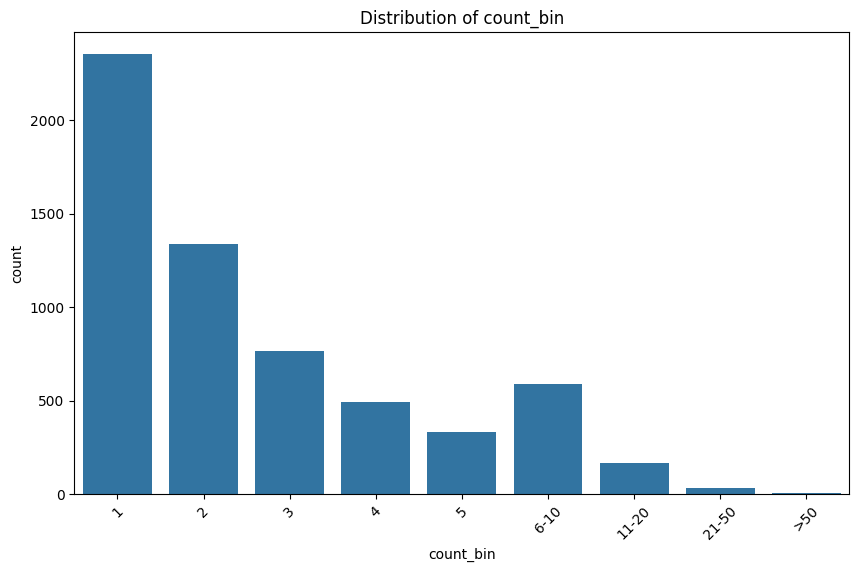

In [154]:
df_sig_dist = df.copy()
category_counts = df_sig_dist['signature_id'].value_counts()
bins = [0, 1, 2, 3, 4, 5, 10, 20, 50, float('inf')]
labels = ['1', '2', '3', '4', '5', '6-10', '11-20', '21-50', '>50']
category_bins = pd.cut(category_counts, bins=bins, labels=labels, right=True)
category_bins_df = category_bins.reset_index()
category_bins_df.columns = ['signature_id', 'count_bin']
get_dist_by_nb(category_bins_df, ['count_bin'])

The following graph showcases the signature IDs occurring the most in the dataset (top 5)

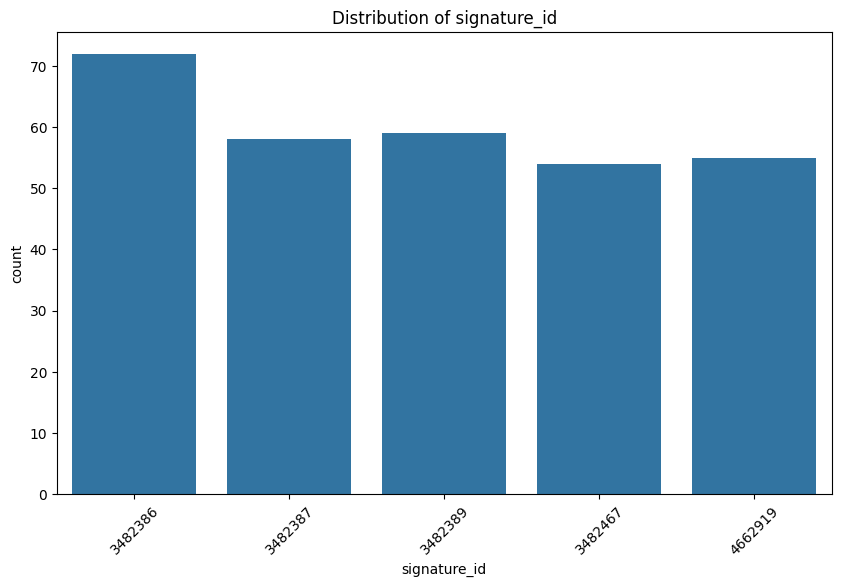

In [155]:
n = 5
top_n_categories = df['signature_id'].value_counts().nlargest(n).index
filtered_df = df[df['signature_id'].isin(top_n_categories)]
get_dist_by_nb(filtered_df, ['signature_id'])

In [156]:
most_frequent_signatures = [3482386, 3482387, 3482389, 3482467, 4662919]

The following showcases the top 3 signature IDs associated with true positive alerts

In [157]:
filtered_df = df[df['alert_status'].isin(["backedout", "fixed", "improvement"])]
sig_counts = filtered_df['signature_id'].value_counts()
top_3_sig = sig_counts.nlargest(3).index
result_df = filtered_df[filtered_df['signature_id'].isin(top_3_sig)]
print(result_df["signature_id"].value_counts())
top_tp_sig = [3779889, 3779886, 3891453]

signature_id
3779889    11
3779886    10
3891453    10
Name: count, dtype: int64


The following showcases the top 3 signature IDs associated with false positive alerts

In [158]:
filtered_df = df[df['alert_status'].isin(["wontfix", "invalid"])]
sig_counts = filtered_df['signature_id'].value_counts()
top_3_sig = sig_counts.nlargest(3).index
result_df = filtered_df[filtered_df['signature_id'].isin(top_3_sig)]
print(result_df["signature_id"].value_counts())
top_fp_sig = [2259234, 2680290, 4669835]

signature_id
2259234    30
2680290    19
4669835    17
Name: count, dtype: int64


In [159]:
def display_sample_2(dataf, sig_id, date_delta=None):
    sample_df = dataf.copy()
    sample_df = sample_df[sample_df["signature_id"] == sig_id]
    if date_delta:
        sample_df = sample_df[sample_df["push_timestamp"] > date_delta]
    sample_df.set_index('push_timestamp', inplace=True)

    #plt.figure(figsize=(12, 8))
    plt.figure(figsize=(20, 10))
    color_mapping = {
        'TP': 'green',
        'FP': 'red',
        'SP': 'grey',
        'TN': 'blue'
    }

    for idx, row in sample_df.iterrows():
        plt.plot(idx, row['value'], marker='o', markersize=8, color=color_mapping.get(row['alert_status']), alpha=0.6)

        # Add vertical line corresponding to each data point of interest
        if row['alert_status'] in ['TP', 'FP', 'SP']:
            plt.axvline(x=idx, color=color_mapping.get(row['alert_status']), linestyle='--', alpha=0.6)

    plt.title('Time Series Plot')
    plt.xlabel('Date')
    plt.ylabel(f'Test measurement values associated with signature ID {sig_id}')
    #plt.grid(True)
    plt.grid(axis='y')
    plt.xlim(sample_df.index.min(), sample_df.index.max())
    y_min = 0
    y_max = sample_df['value'].max() * 2
    plt.ylim(bottom=y_min, top=y_max)
    '''
    plt.ylim(bottom=0)
    xticks = sample_df.index[::10]
    plt.xticks(xticks, rotation=45)'''
    start_date = sample_df.index.min()
    end_date = sample_df.index.max()
    weekly_ticks = pd.date_range(start=start_date, end=end_date, freq='W-MON')
    plt.xticks(weekly_ticks, rotation=45)
    plt.show()
'''
date_x_days_ago = datetime(2024, 5, 15) - timedelta(days=365)
print(4768977)
display_sample_2(df_final, 4768977, date_x_days_ago)

print(4768979)
display_sample_2(df_final, 4768979, date_x_days_ago)

print(4768980)
display_sample_2(df_final, 4768980, date_x_days_ago)

print(4769032)
display_sample_2(df_final, 4769032, date_x_days_ago)'''

'\ndate_x_days_ago = datetime(2024, 5, 15) - timedelta(days=365)\nprint(4768977)\ndisplay_sample_2(df_final, 4768977, date_x_days_ago)\n\nprint(4768979)\ndisplay_sample_2(df_final, 4768979, date_x_days_ago)\n\nprint(4768980)\ndisplay_sample_2(df_final, 4768980, date_x_days_ago)\n\nprint(4769032)\ndisplay_sample_2(df_final, 4769032, date_x_days_ago)'

In [160]:
def display_sample(dataf, sig_id, date_delta=None):
  sample_df = dataf.copy()
  sample_df = sample_df[sample_df["signature_id"] == sig_id]
  display(sample_df.head(5))
  if date_delta:
    sample_df = sample_df[sample_df["push_timestamp"] > date_delta]
    display(sample_df.head(5))
  sample_df.set_index('push_timestamp', inplace=True)
  plt.figure(figsize=(10, 6))
  plt.plot(sample_df.index, sample_df['value'], marker='o', linestyle='-')
  plt.title('Time Series Plot')
  plt.xlabel('Date')
  plt.ylabel('Test measurement values associated with signature ID ' + str(sig_id))
  plt.grid(True)
  plt.show()

In [161]:
df1 = pd.read_csv(extension + '/autoland4/3482386_timeseries_data.csv')
df2 = pd.read_csv(extension + '/autoland4/3482387_timeseries_data.csv')
df3 = pd.read_csv(extension + '/autoland4/3482389_timeseries_data.csv')
df4 = pd.read_csv(extension + '/autoland4/3482467_timeseries_data.csv')
df5 = pd.read_csv(extension + '/autoland2/4662919_timeseries_data.csv')
df6 = pd.read_csv(extension + '/autoland4/3779889_timeseries_data.csv')
df7 = pd.read_csv(extension + '/autoland4/3779886_timeseries_data.csv')
df8 = pd.read_csv(extension + '/mozilla-beta/3891453_timeseries_data.csv')
df9 = pd.read_csv(extension + '/autoland4/2259234_timeseries_data.csv')
df10 = pd.read_csv(extension + '/autoland4/2680290_timeseries_data.csv')
df11 = pd.read_csv(extension + '/firefox-android/4669835_timeseries_data.csv')
df12 = pd.read_csv(extension + '/autoland3/4375303_timeseries_data.csv')
df13 = pd.read_csv(extension + '/autoland4/3777127_timeseries_data.csv')
df14 = pd.read_csv(extension + '/autoland2/4405631_timeseries_data.csv')
timeseries_df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14], ignore_index=True).drop_duplicates()
timeseries_df['push_timestamp'] = timeseries_df['push_timestamp'].str.replace("'", "", regex=False)
timeseries_df['push_timestamp'] = pd.to_datetime(timeseries_df['push_timestamp'], format='%Y-%m-%d %H:%M:%S')

<ipython-input-161-dffa4da83d26>:9: DtypeWarning: Columns (47,49) have mixed types. Specify dtype option on import or set low_memory=False.
  df9 = pd.read_csv(extension + '/2259234_timeseries_data.csv')
<ipython-input-161-dffa4da83d26>:10: DtypeWarning: Columns (47,49,76,83) have mixed types. Specify dtype option on import or set low_memory=False.
  df10 = pd.read_csv(extension + '/2680290_timeseries_data.csv')


In [162]:
def print_unique_entries_count(dataf, unique_entry, col):
  print("Number of unique signatures associated with the " + str(unique_entry) + " value of column " + col)
  if (str(unique_entry) == "nan"):
    print(len(dataf[dataf[col].isnull()]["signature_id"].unique()))
  else:
    print(len(dataf[dataf[col] == unique_entry]["signature_id"].unique()))

In [163]:
for measure_unit in timeseries_df["measurement_unit"].unique():
  print_unique_entries_count(timeseries_df, measure_unit, "measurement_unit")

Number of unique signatures associated with the nan value of column measurement_unit
8
Number of unique signatures associated with the ms value of column measurement_unit
5
Number of unique signatures associated with the bytes value of column measurement_unit
1


In [164]:
print(list(set(timeseries_df.columns.tolist()) - set(df.columns.tolist())))
print(list(set(df.columns.tolist()) - set(timeseries_df.columns.tolist())))

['extra_options', 'has_subtests', 'revision', 'option_collection_hash', 'repository_id', 'parent_signature', 'test', 'repository_name', 'tags', 'should_alert', 'measurement_unit', 'name', 'signature_hash', 'lower_is_better', 'job_id', 'application', 'entry_id', 'value', 'push_timestamp', 'test_series_signature_framework_id', 'suite', 'machine_platform', 'push_id', 'framework_id']
['alert_revision']


In [165]:
common_columns = list(set(df.columns).intersection(set(timeseries_df.columns)) - {'revision', 'alert_revision', 'signature_id', 'alert_revision'})
timeseries_df_extended = timeseries_df.drop(columns=common_columns)
df_merged = pd.merge(timeseries_df_extended, df, left_on=['revision', 'signature_id'], right_on=['alert_revision', 'signature_id'], how='left', suffixes=('', ''))
df_merged['alert_status'].fillna('TN', inplace=True)
df_final = df_merged.drop_duplicates()
df_final.drop(columns=['alert_revision'], inplace=True)

In [166]:
category_mapping = {
    'investigating': 'SP', # 'SP' stands for 'Still Processing'
    'reassigned': 'SP',
    'invalid': 'FP',
    'improvement': 'TP',
    'fixed': 'TP',
    'wontfix': 'FP',
    'untriaged': 'SP',
    'backedout': 'TP'
}
df_final["alert_status"] = df_final["alert_status"].replace(category_mapping)

In [167]:
category_counts = df_sig_dist['signature_id'].value_counts()
average_count = category_counts.mean()
median_count = category_counts.median()
print(f"Signatures average count: {average_count:.2f}")
print(f"Signatures median count: {median_count:.2f}")

Signatures average count: 3.12
Signatures median count: 2.00


The following represents the distribution of the alert statuses across the selected signatures

In [168]:
percentage_counts = df_final['alert_status'].value_counts(normalize=True) * 100
print(percentage_counts)

alert_status
TN    98.982325
SP     0.648835
FP     0.258457
TP     0.110383
Name: proportion, dtype: float64


In [169]:
df_final["alert_status"] = df_final["alert_status"].replace(category_mapping)

In [170]:
date_one_year_ago = datetime(2024, 5, 15) - timedelta(days=365)
def display_sig_characteristics(sig_id):
  print("characteristics of signature ID " + str(sig_id))
  display_sample_2(df_final, sig_id, date_one_year_ago)
  subject_sig_df = df_final[df_final['signature_id'] == sig_id]
  percentage_counts = subject_sig_df['alert_status'].value_counts(normalize=True) * 100
  print(percentage_counts)

The following visualization is consisted of timeseries plots as well as alert status distribution for most occurring signatures in the alerts during the last year

characteristics of signature ID 3482386


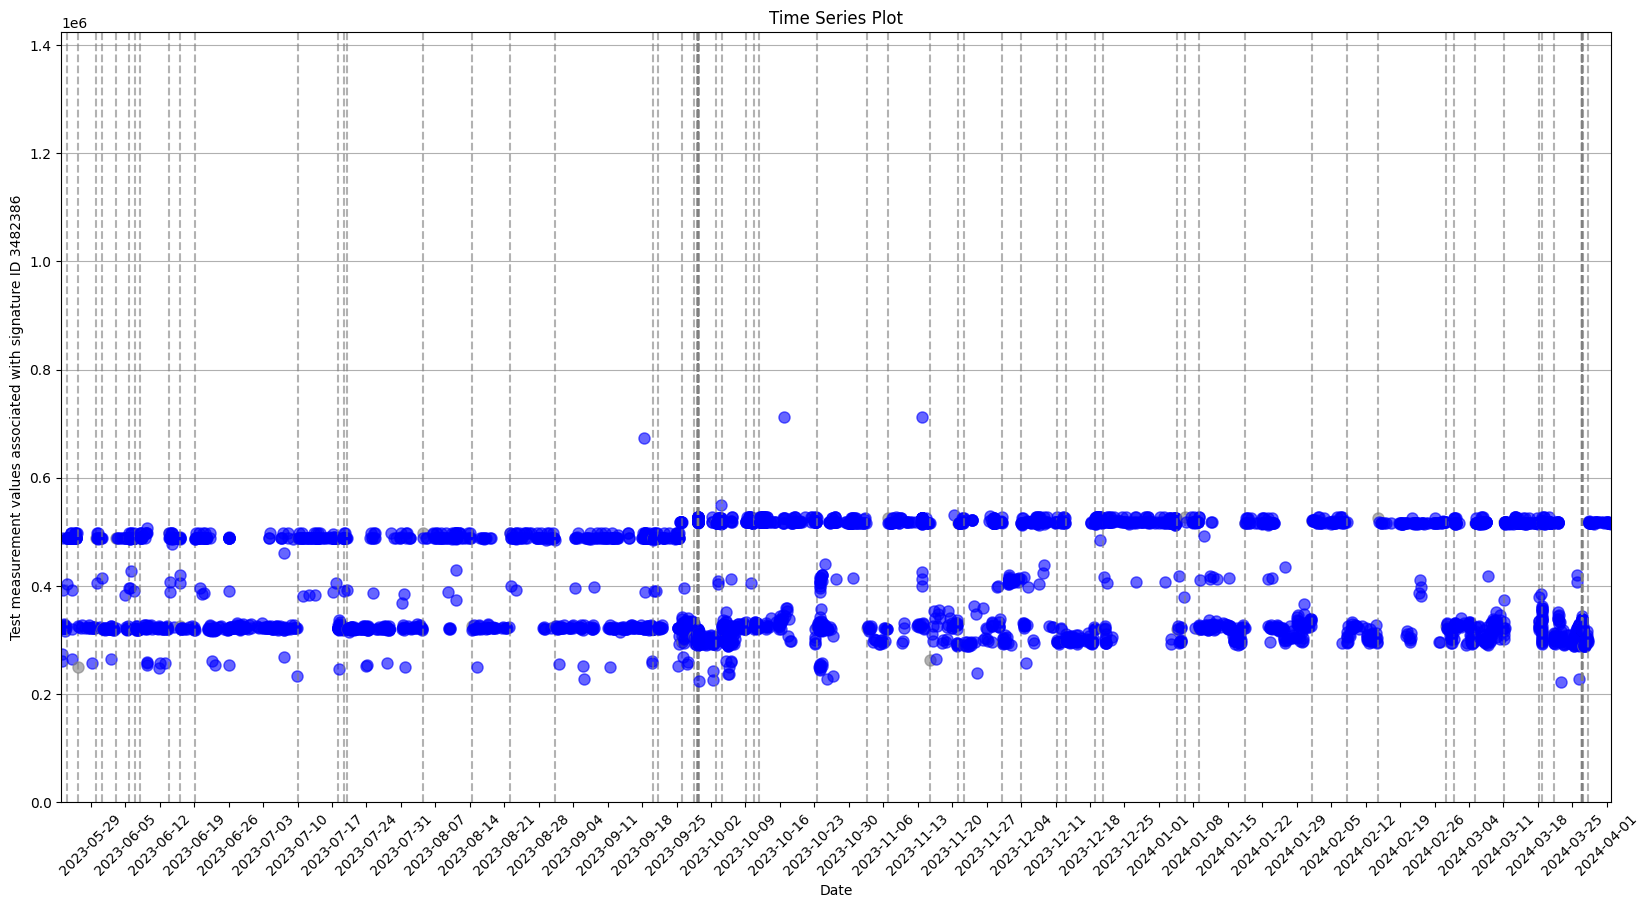

alert_status
TN    97.808808
SP     2.191192
Name: proportion, dtype: float64
characteristics of signature ID 3482387


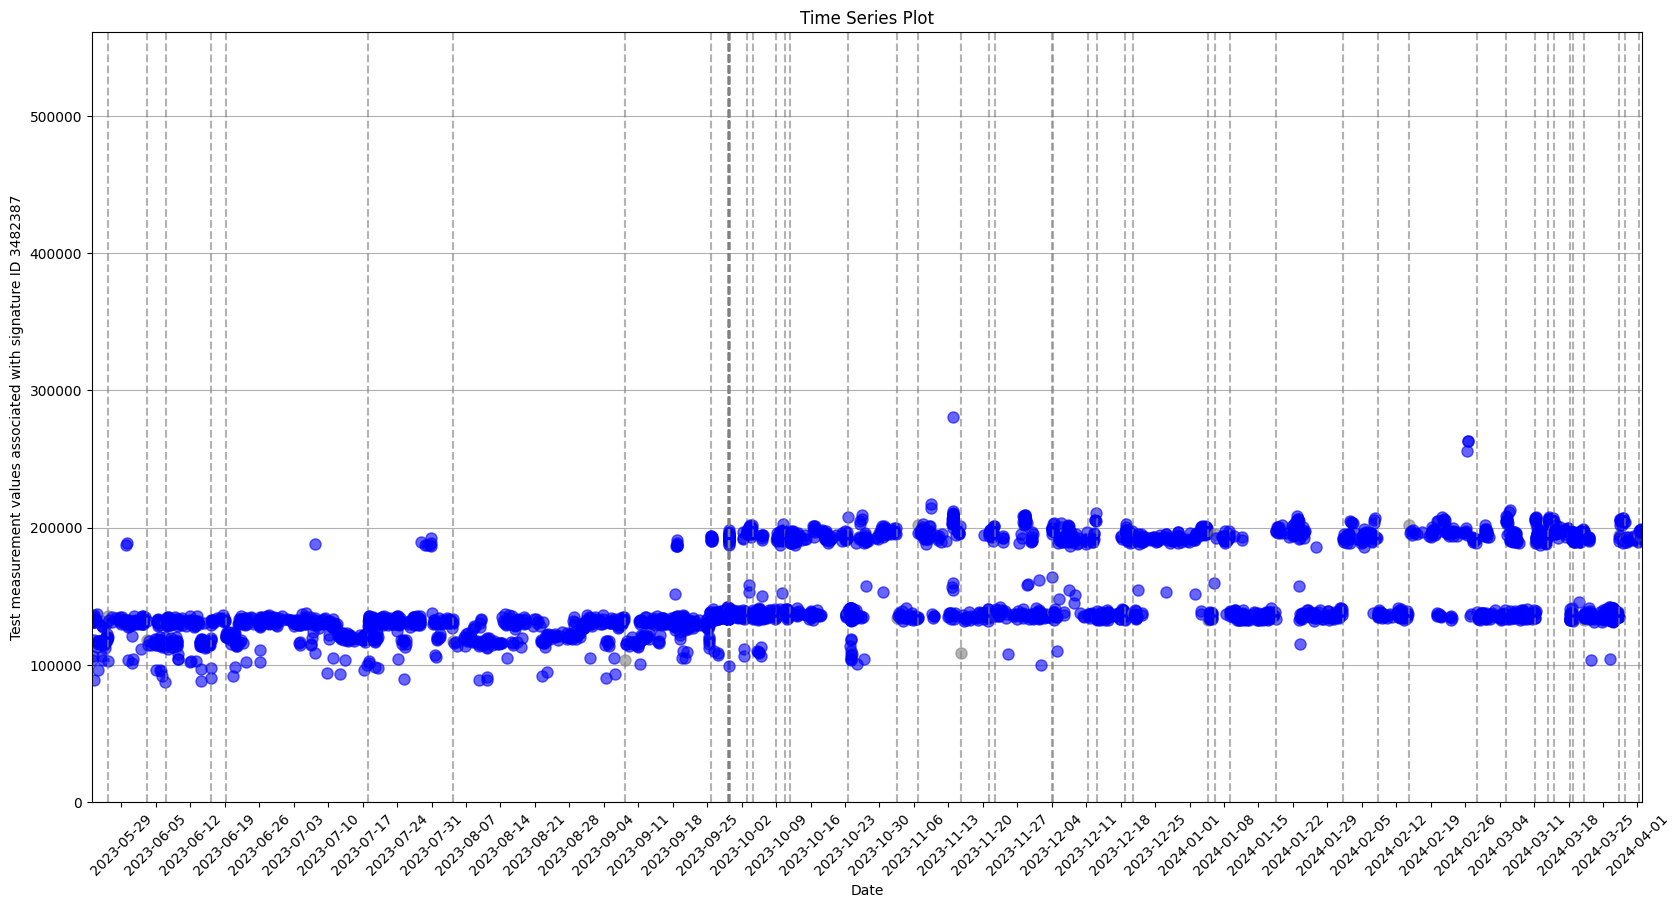

alert_status
TN    98.324382
SP     1.675618
Name: proportion, dtype: float64
characteristics of signature ID 3482389


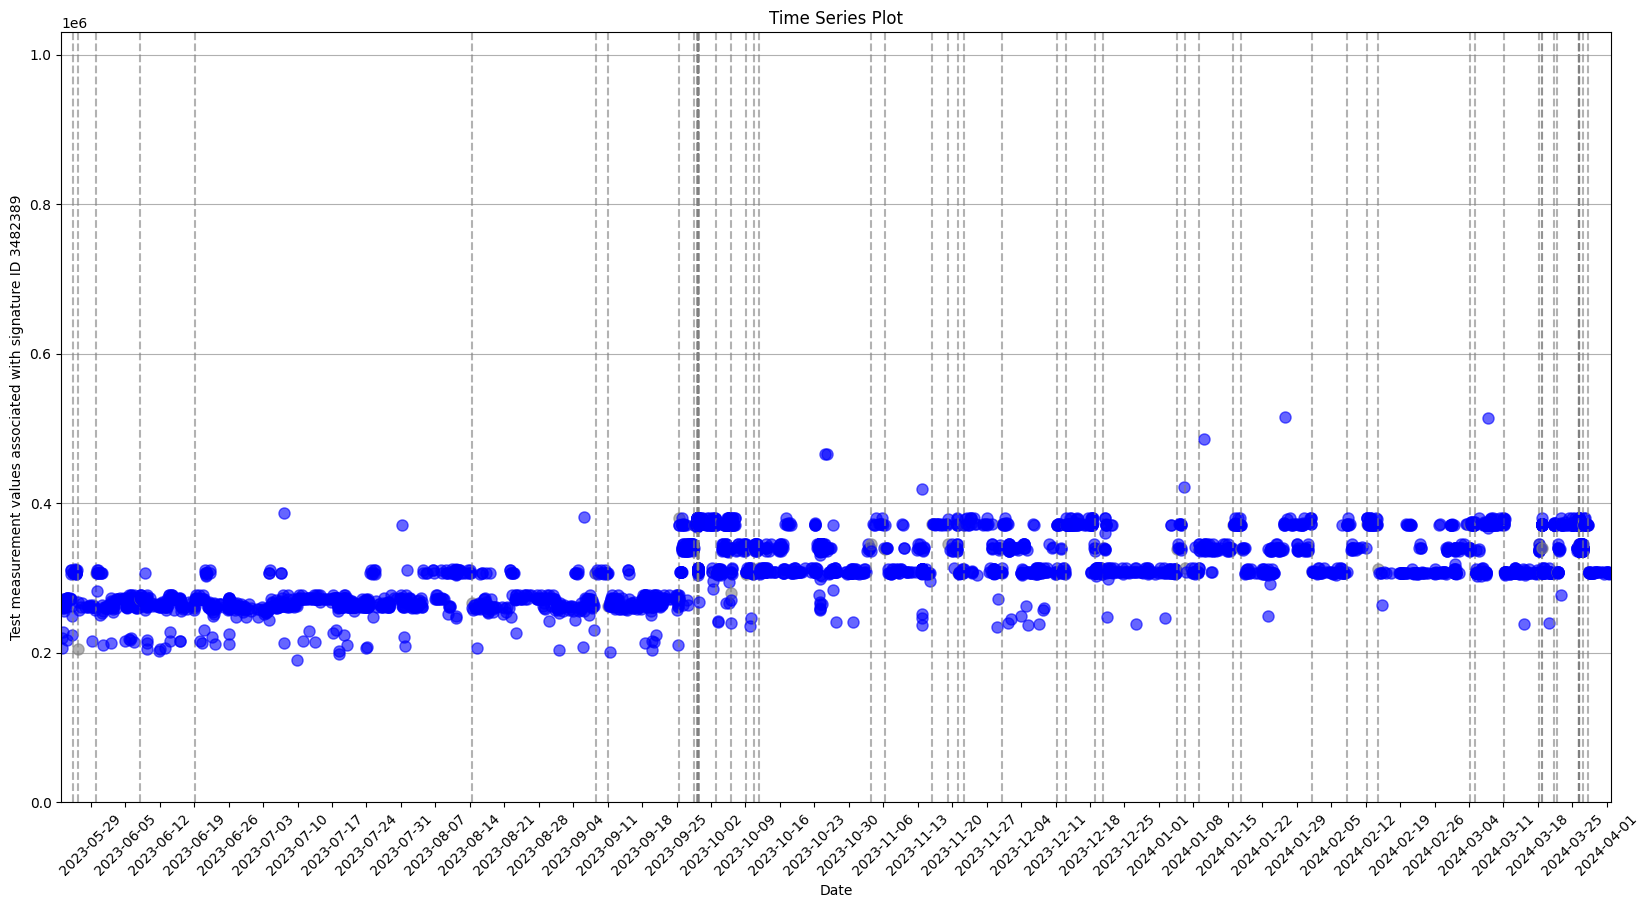

alert_status
TN    98.174006
SP     1.825994
Name: proportion, dtype: float64
characteristics of signature ID 3482467


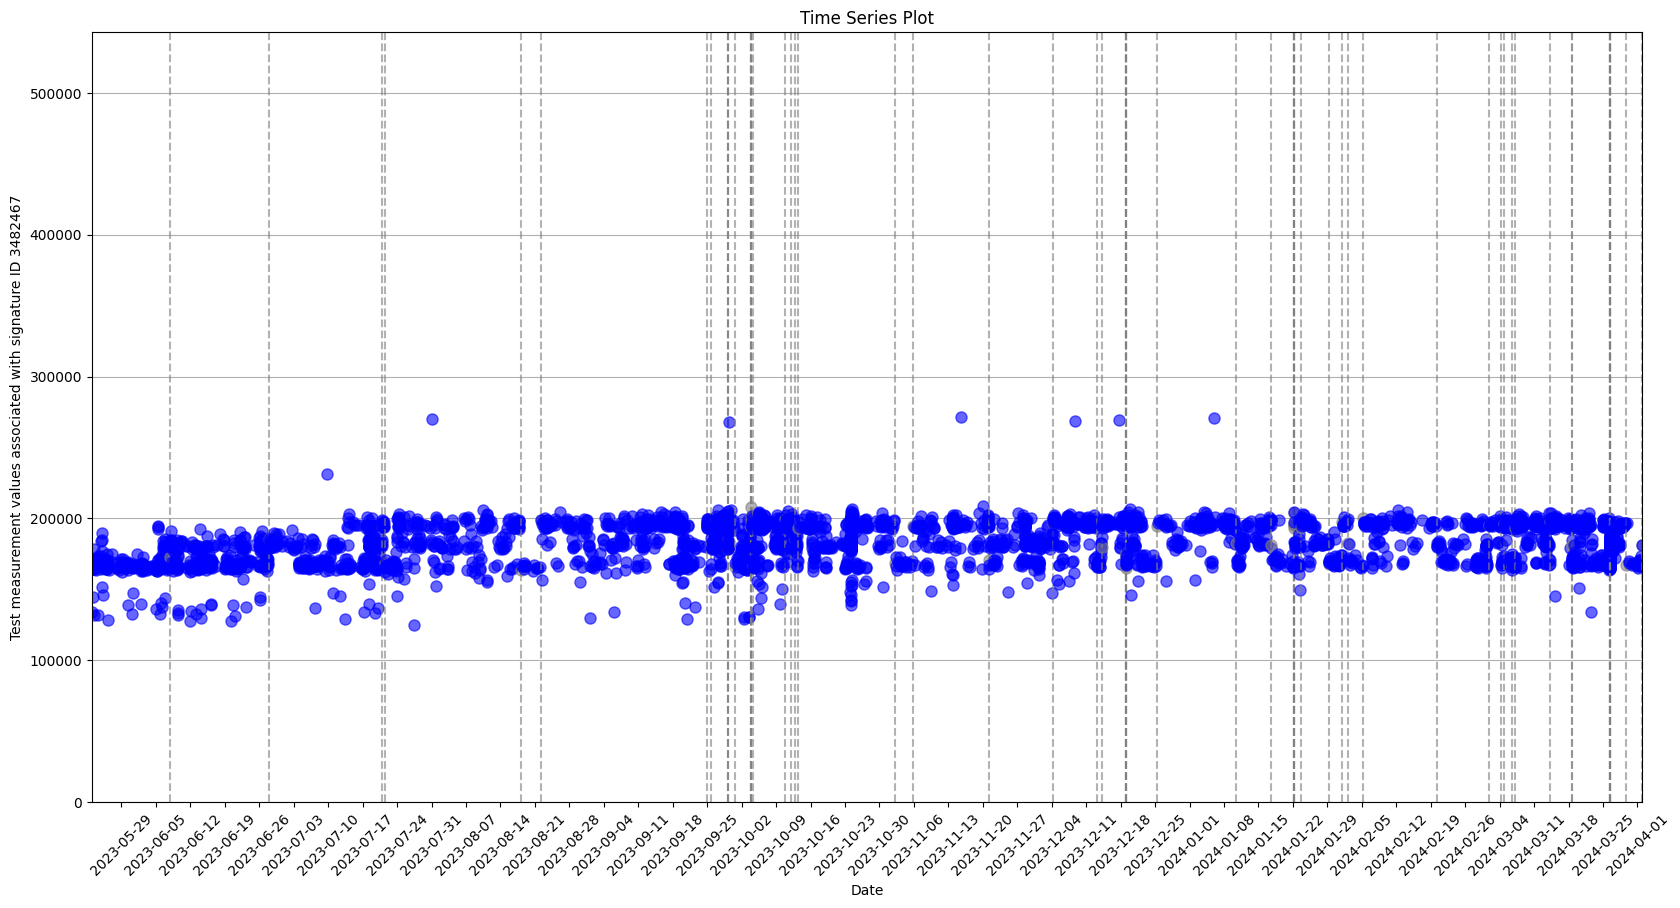

alert_status
TN    98.668099
SP     1.331901
Name: proportion, dtype: float64
characteristics of signature ID 4662919


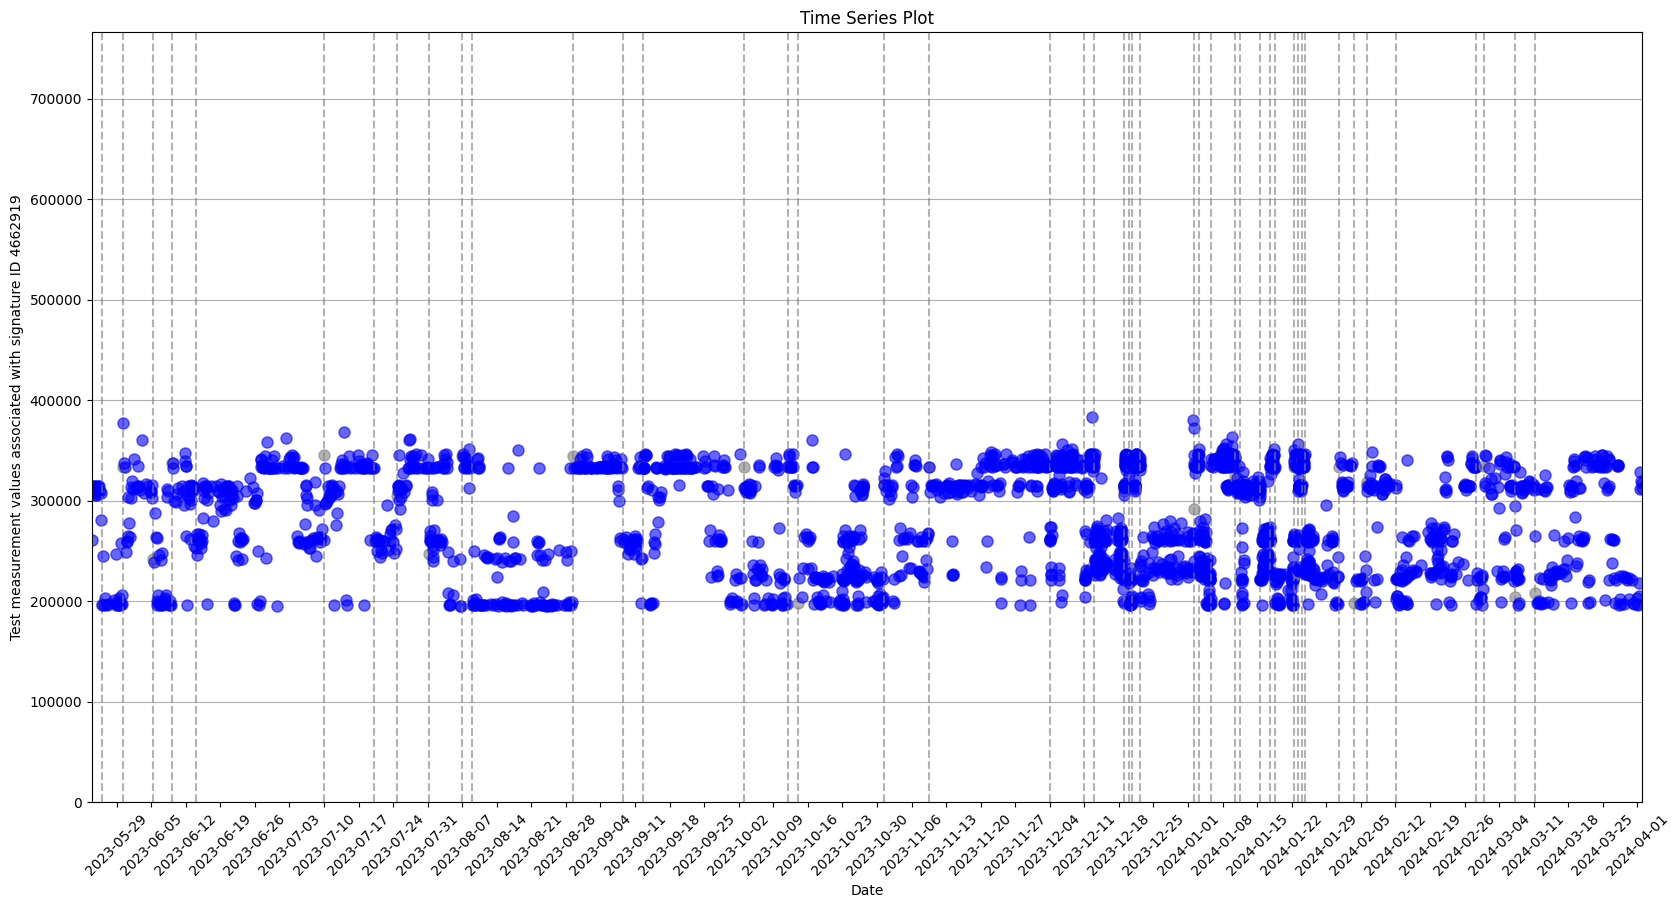

alert_status
TN    98.351254
SP     1.648746
Name: proportion, dtype: float64


In [171]:
for sig in most_frequent_signatures:
  display_sig_characteristics(sig)

The following visualization is consisted of timeseries plots as well as alert status distribution for signatures associated with true positive alerts the most

characteristics of signature ID 3779889
characteristics of signature ID 3779889


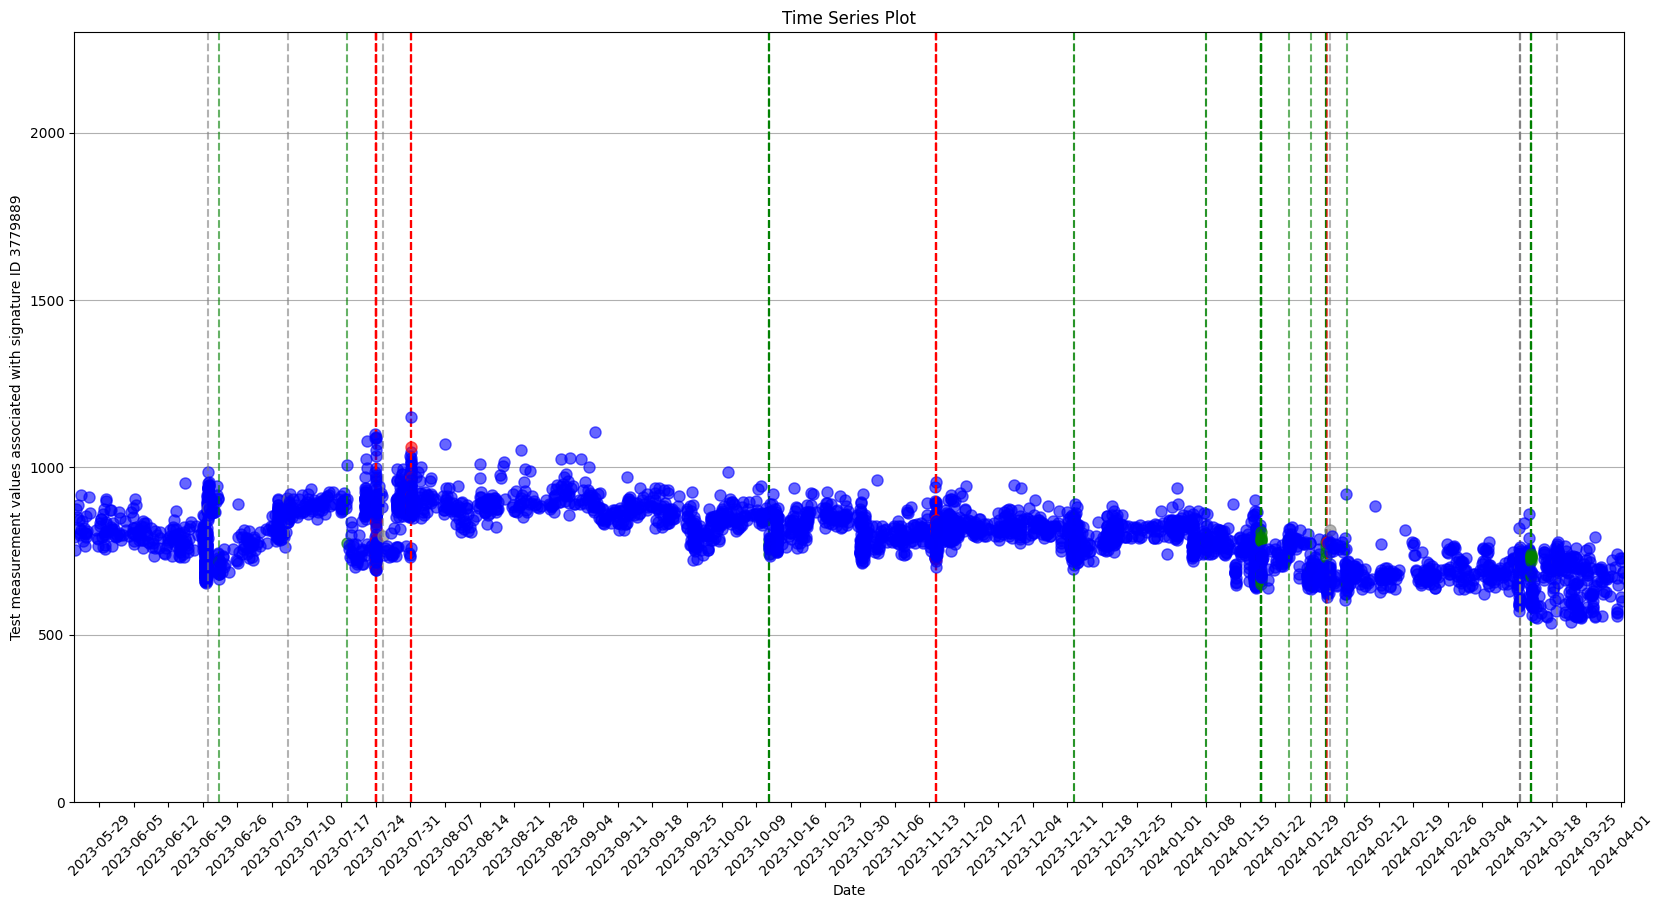

alert_status
TN    98.511218
TP     0.754875
FP     0.545188
SP     0.188719
Name: proportion, dtype: float64
characteristics of signature ID 3779886
characteristics of signature ID 3779886


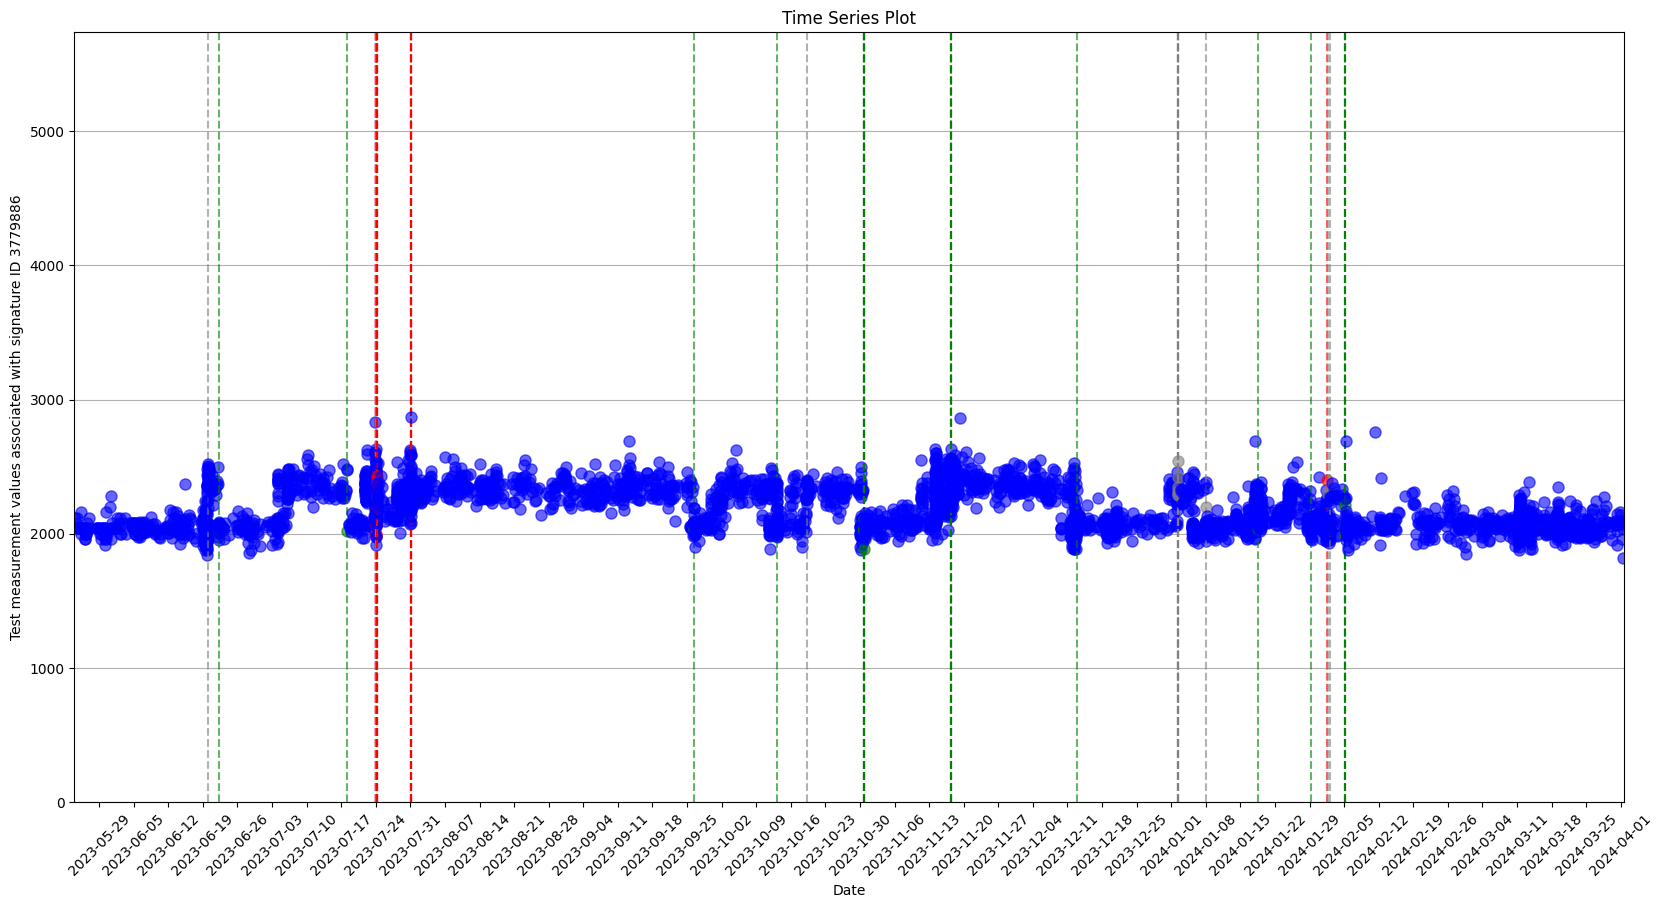

alert_status
TN    98.699937
FP     0.503250
TP     0.461313
SP     0.335500
Name: proportion, dtype: float64
characteristics of signature ID 3891453
characteristics of signature ID 3891453


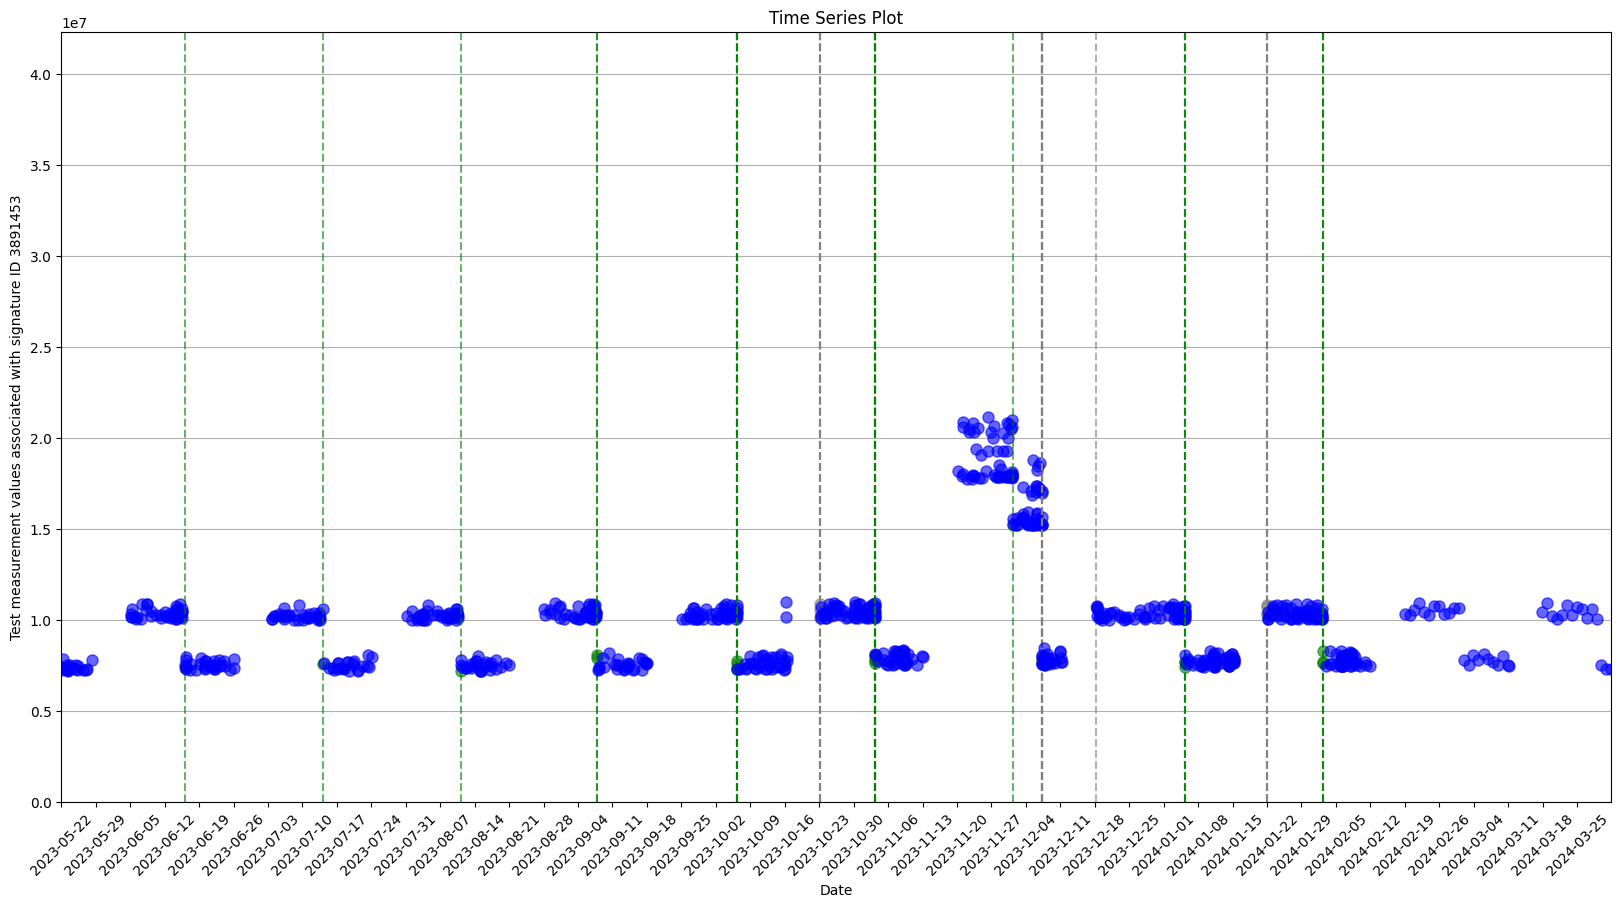

alert_status
TN    95.995551
TP     2.335929
SP     1.668521
Name: proportion, dtype: float64


In [172]:
for sig in top_tp_sig:
  print("characteristics of signature ID " + str(sig))
  display_sig_characteristics(sig)

The following visualization is consisted of timeseries plots as well as alert status distribution for signatures associated with false positive alerts the most

characteristics of signature ID 2259234
characteristics of signature ID 2259234


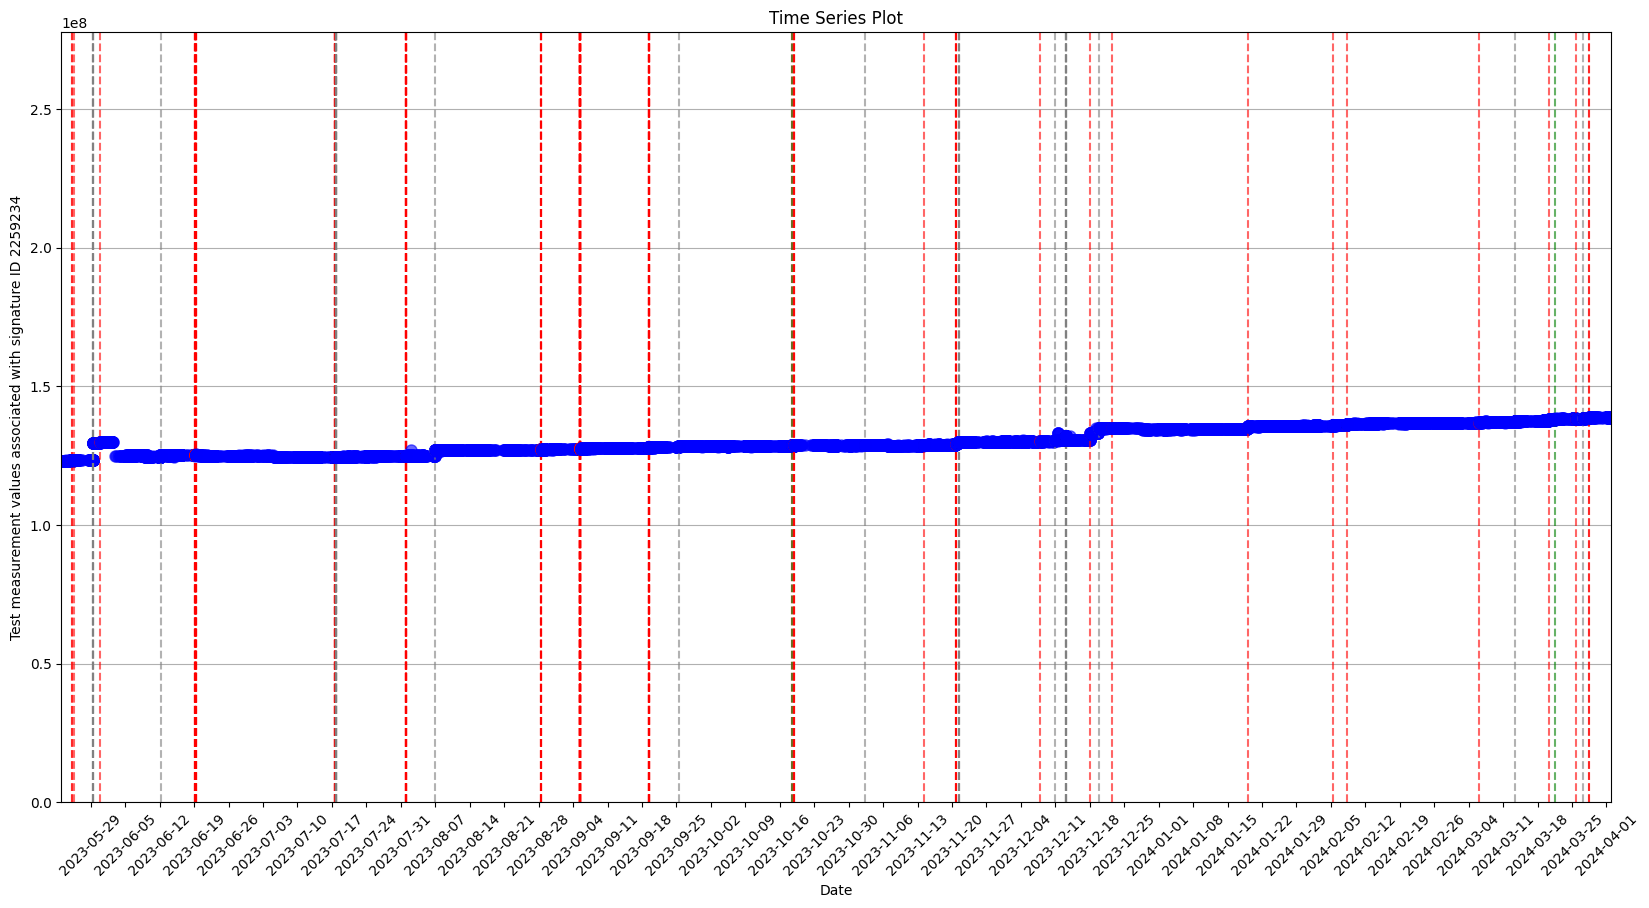

alert_status
TN    98.954593
FP     0.758120
SP     0.271327
TP     0.015960
Name: proportion, dtype: float64
characteristics of signature ID 2680290
characteristics of signature ID 2680290


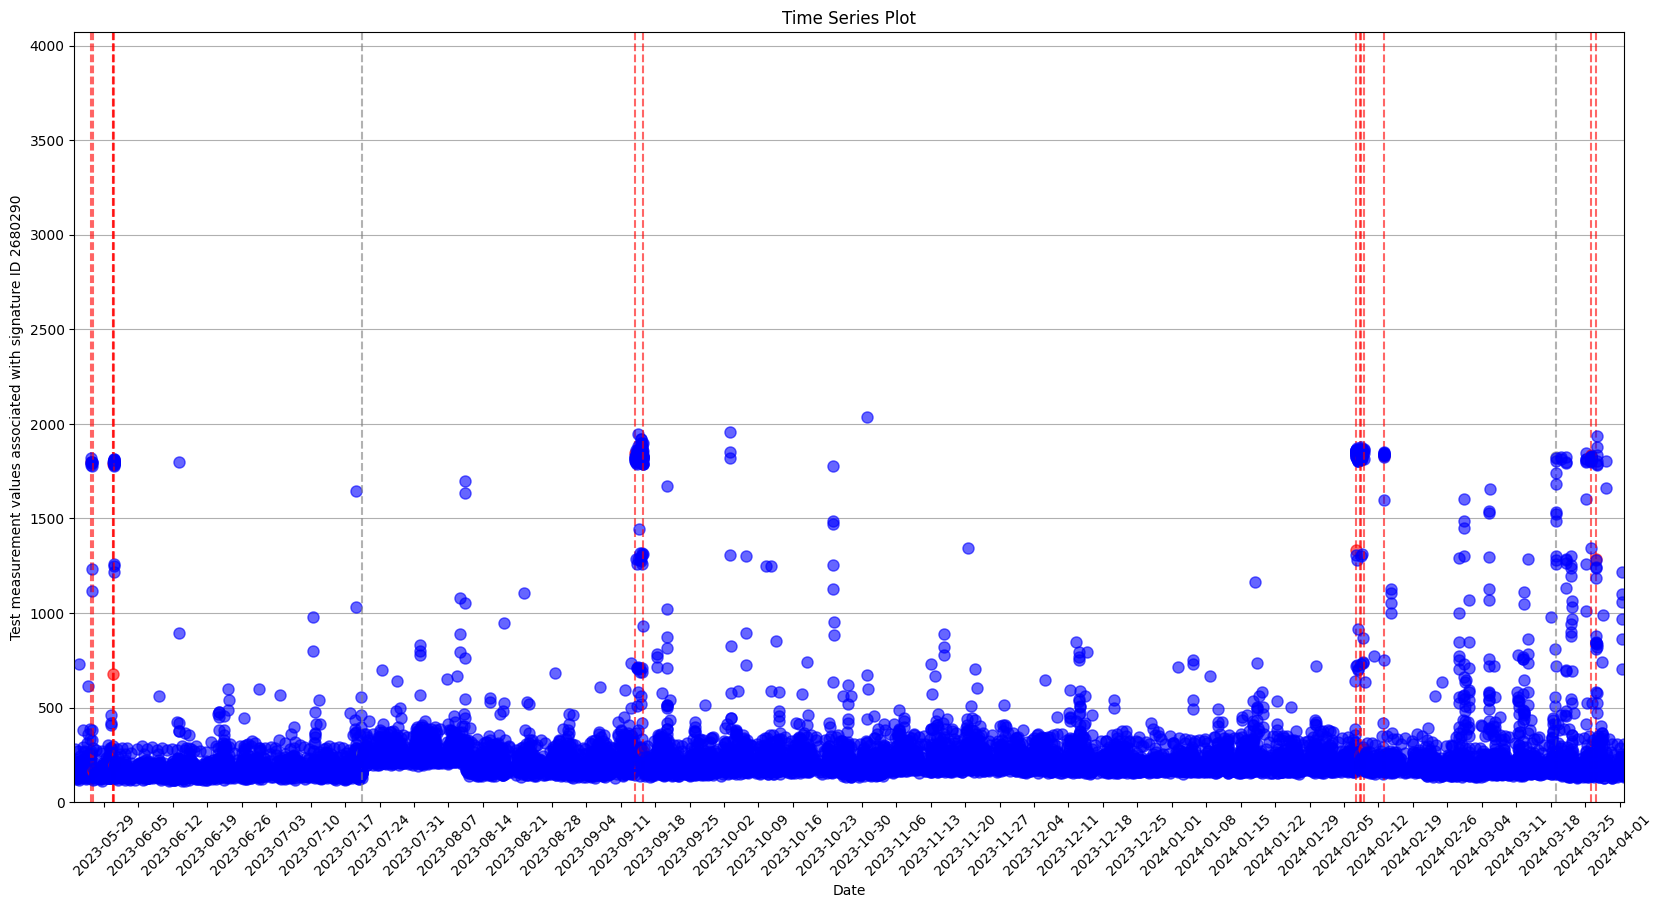

alert_status
TN    99.916900
FP     0.072712
SP     0.010387
Name: proportion, dtype: float64
characteristics of signature ID 4669835
characteristics of signature ID 4669835


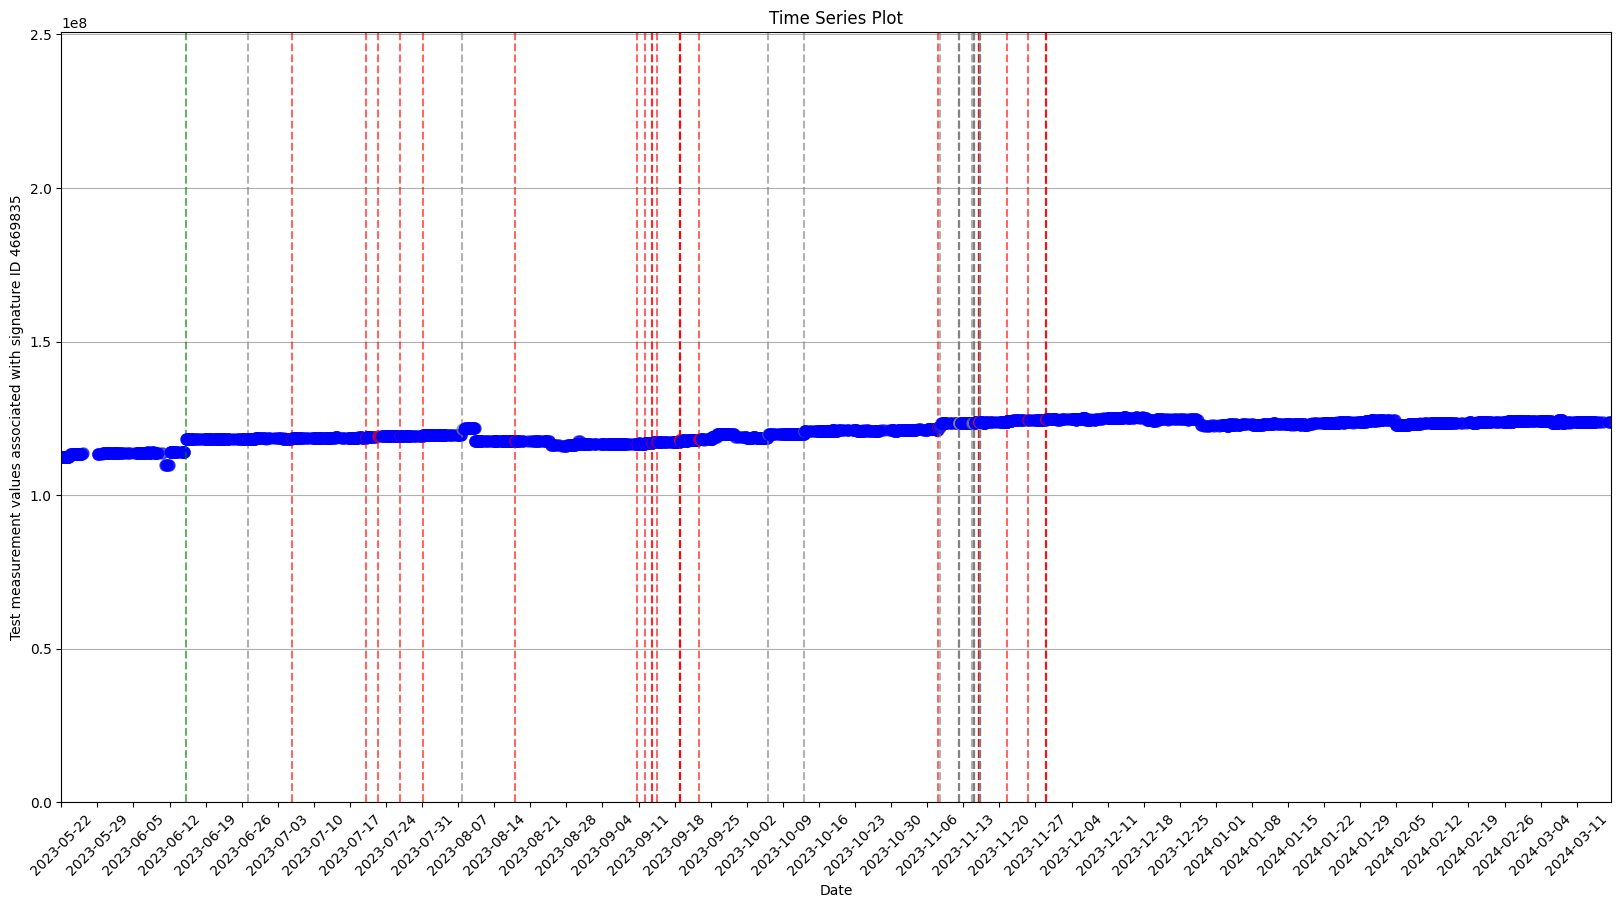

alert_status
TN    98.121713
FP     1.051841
SP     0.788881
TP     0.037566
Name: proportion, dtype: float64


In [173]:
for sig in top_fp_sig:
  print("characteristics of signature ID " + str(sig))
  display_sig_characteristics(sig)

In [174]:
display(df[df['signature_id'] == 3779889])

,alert_id,alert_push_id,alert_prev_push_id,alert_creation_timestamp,alert_first_triaged,alert_triage_due_date,alert_repository,alert_framework,test_id,test_status,signature_id,test_series_signature_signature_hash,test_series_signature_machine_platform,test_series_signature_test,test_series_signature_suite,test_series_signature_lower_is_better,test_series_signature_has_subtests,test_series_signature_option_collection_hash,test_series_signature_tags,test_series_signature_extra_options,test_series_signature_measurement_unit,test_series_signature_suite_public_name,test_series_signature_test_public_name,test_prev_taskcluster_metadata_task_id,test_prev_taskcluster_metadata_retry_id,test_taskcluster_metadata_task_id,test_taskcluster_metadata_retry_id,test_profile_url,test_prev_profile_url,test_is_regression,test_prev_value,test_new_value,test_t_value,test_amount_abs,test_amount_pct,test_summary_id,test_related_summary_id,test_manually_created,test_classifier,test_starred,test_classifier_email,test_backfill_record_context,test_backfill_record_status,test_backfill_record_total_actions_triggered,test_backfill_record_total_backfills_failed,test_backfill_record_total_backfills_successful,test_backfill_record_total_backfills_in_progress,test_noise_profile,alert_related_alerts,alert_status,alert_bug_number,alert_bug_due_date,alert_bug_updated,alert_issue_tracker,alert_notes,alert_revision,alert_push_timestamp,alert_prev_push_revision,alert_assignee_username,alert_assignee_email,alert_performance_tags
371,44,1418368,1418348,2024-05-02 00:08:54.558066,2024-05-07 06:51:13.119962,2024-05-07 00:08:54.558066,autoland,browsertime,109,untriaged,3779889,c4f892cc50a210c0a378d832b099feb180ae9149,macosx1015-64-shippable-qr,PerceptualSpeedIndex,espn,True,False,102210fe594ee9b33d82058545b1ed14f4c8206e,"cold, fission, webrender","cold, fission, webrender",ms,NaN,NaN,R-CqbINKTmK-fmXeuZVQwA,0.0,GIRiF9AYSeWrer5A4am84A,0.0,NaN,NaN,False,723.68,597.37,9.81,-126.31,17.45,44,NaN,False,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OK,NaN,untriaged,NaN,2024-05-09 00:08:54.558066,NaT,1,NaN,26390589f165128dffd39f91181ed9c9daf7afaa,2024-04-30 09:34:04,5502377f2629549b2b7c5368c980d0487ed281d4,mozilla-ldap/afinder@mozilla.com,afinder@mozilla.com,NaN
515,42343,1412150,1412057,2024-04-22 21:51:32.114758,2024-04-23 09:16:36.964525,2024-04-25 21:51:32.114758,autoland,browsertime,193651,acknowledged,3779889,c4f892cc50a210c0a378d832b099feb180ae9149,macosx1015-64-shippable-qr,PerceptualSpeedIndex,espn,True,False,102210fe594ee9b33d82058545b1ed14f4c8206e,"cold, fission, webrender","cold, fission, webrender",ms,NaN,NaN,J2e0SXs3QCWxoDQIaXBu7Q,0.0,JwbFLo_eSHGB9sz7Hzt3Yw,0.0,NaN,NaN,False,754.26,648.77,9.41,-105.49,13.99,42343,NaN,False,mozilla-ldap/bacasandrei@mozilla.com,True,bacasandrei@mozilla.com,NaN,NaN,NaN,NaN,NaN,NaN,OK,NaN,investigating,NaN,2024-04-29 21:51:32.114758,NaT,1,NaN,465ebfc7da3d3a6de812574016249ab37ab8605c,2024-04-19 10:27:22,99364906cd1d11016d0fc2dc03a8b7fd11705aa4,mozilla-ldap/bacasandrei@mozilla.com,bacasandrei@mozilla.com,infra
784,42295,1409875,1409649,2024-04-18 06:35:45.707721,2024-04-22 12:46:47.908618,2024-04-23 06:35:45.707721,autoland,browsertime,193378,acknowledged,3779889,c4f892cc50a210c0a378d832b099feb180ae9149,macosx1015-64-shippable-qr,PerceptualSpeedIndex,espn,True,False,102210fe594ee9b33d82058545b1ed14f4c8206e,"cold, fission, webrender","cold, fission, webrender",ms,NaN,NaN,UQH6Fu-MQ0WVj8icHqXEZw,0.0,BpZxT5UvQReQf-0DQRLVkQ,0.0,NaN,NaN,True,637.13,759.92,7.97,122.79,19.27,42295,NaN,False,mozilla-ldap/afinder@mozilla.com,False,afinder@mozilla.com,NaN,NaN,NaN,NaN,NaN,NaN,SKEWED,NaN,investigating,NaN,2024-04-25 06:35:45.707721,NaT,1,NaN,12c7f0b00cd7ce4e2edde6ff37daf12e807388b1,2024-04-16 17:33:30,11d1c89ad8b2dad0cee1caf733cd833e448945eb,mozilla-ldap/afinder@mozilla.com,afinder@mozilla.com,infra
2592,41894,1394711,1394632,2024-03-20 09:00:15.895435,2024-03-21 08:18:56.760179,2024-03-25 09:00:15.895435,autoland,browsertime,191518,acknowledged,3779889,c4f892c